In [ ]:

import torch
import os

if torch.cuda.is_available():
    # clone repo 
    !git clone -b NN_train https://github.com/I-Zuniga/Event_Star_tracker.git

    path = os.getcwd()
    os.sys.path.insert(0, '/content/Event_Star_tracker')

    print(path)

    # Define what device we are using
    use_cuda=True
    print("CUDA Available: ",torch.cuda.is_available())
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    print(device)

else:
    # Get system path 
    import os
    path = os.getcwd()
    # Get parent directory
    parent = os.path.dirname(path)
    #Add parent directory to system path
    os.sys.path.insert(0, parent)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform
from scipy.spatial import KDTree
from sympy import flatten


from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *

import torch
import torch.nn as nn
import torch.nn.functional as F

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4560 rows x 9 columns]
Data shape:  (4560, 3)
Star ID (HIP):  

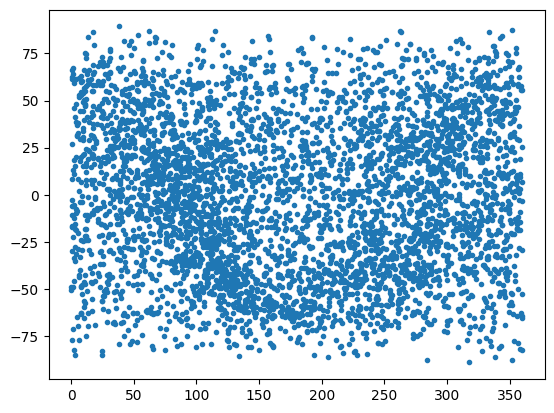

In [3]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
if torch.cuda.is_available():
    catalog_path = '/content/Event_Star_tracker/data/catalogs/tycho2_VT_6.csv'
else:
    catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

# Delete stars with missing HIP
stars_data = stars_data[~np.isnan(stars_data['HIP'])]

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID (HIP): ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [10]:
# data augmetation 

from typing import final


print("Original data shape: ", stars_data.shape)

stars_data_augmented = np.copy(stars_data)
for j in range(2):
    for i in range(1,5):
        stars_copy = np.copy(stars_data)
        noise= np.random.normal(loc=1, scale=0.0005*i, size=stars_copy[:,1:3].shape)
        stars_copy[:,1:3] *= noise
        stars_data_augmented = np.concatenate((stars_data_augmented, stars_copy), axis=0)

print("Augmented data shape: ", stars_data_augmented.shape)

Original data shape:  (4560, 3)
Augmented data shape:  (41040, 3)


In [11]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data_augmented[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data_augmented[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data_augmented)):
    # print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        # print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")


    features_1, features_2 = get_star_features(stars_data_augmented[indices[i][0:n_of_neighbor+1]][:,1:3], 1, 1, 1)
    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)
    # print('features_1: ', features_1)
    # print('features_2: ', features_2)

    # print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )
    # print('----------------------')

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min()) / (star_features.max() - star_features.min())
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))



In [12]:
# Join features into 1 array 
features = np.append(features_1_n, features_2_n, axis=1)
features = torch.tensor(features, dtype=torch.float32)
print("Features shape: ", features.shape)

increase = features.shape[0] / stars_data.shape[0]
print("Increase in data: ", increase)

labels = np.array([])
for i in range(int(increase)):
    labels = np.append(labels, np.arange(stars_data.shape[0]), axis=0)

print("Labels shape: ", labels.shape)

Features shape:  torch.Size([41040, 18])
Increase in data:  9.0
Labels shape:  (41040,)


In [13]:


class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Define the input dimension and number of classes
input_dim = features.shape[1]  # Adjust input_dim according to your data
num_classes = stars_data.shape[0]


# Initialize the model
model = Classifier(input_dim, num_classes)

# Print the model architecture
print(model)


Classifier(
  (fc1): Linear(in_features=18, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4560, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:

## SINGLE TRAINING ##
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert the features and labels to tensor
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Train the model
epochs = 500
for e in range(epochs):
    optimizer.zero_grad()
    output = model(features)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    if e % 10 == 0:
        print('Epoch: {}/{}'.format(e, epochs), 'Loss: {}'.format(loss.item()))

# Get the predicted classes
_, predicted = torch.max(model(features).data, 1)

# Print the accuracy
print('Accuracy: {}'.format((predicted == labels).sum().item() / labels.size(0)))


/tmp/ipykernel_16555/1343116238.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/tmp/ipykernel_16555/1343116238.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch: 0/500 Loss: 8.297307968139648
Epoch: 10/500 Loss: 8.25031566619873
Epoch: 20/500 Loss: 8.037005424499512
Epoch: 30/500 Loss: 7.8535590171813965
Epoch: 40/500 Loss: 7.704042434692383
Epoch: 50/500 Loss: 7.6014885902404785
Epoch: 60/500 Loss: 7.509018421173096


Final guess: 3602, actual star ID: 3602


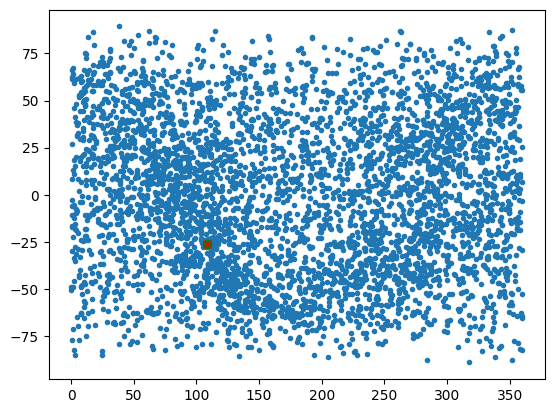

In [244]:
from random import sample
from lib.event_processing import predict_star_id
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))
# random_id = np.where(stars_data[:,0] == 12828)[0][0] # To check the prediction of a specific star (not that random)

sample_feature = features[random_id].reshape(1, -1)

# Get the predicted star ID from the NN
star_guess = nn.Softmax(dim=1)(model(sample_feature)).argmax(1).item()

print(f"Final guess: {star_guess}, actual star ID: {random_id}")

plt.figure()
plt.plot(stars_data[:,1],stars_data[:,2],'.')
plt.plot(stars_data[random_id][1],stars_data[random_id][2],'og')
plt.plot(stars_data[star_guess][1],stars_data[star_guess][2],'xr')
plt.show()


Normal star check

In [245]:
import time 

cont = np.zeros(2) # [Correct match, wrong match ]


stars_pos = np.copy(stars_data[:,1:3])
noise= np.random.normal(loc=1, scale=0.001, size=stars_pos.shape)
mean_noise = np.mean(np.abs(1-noise), axis=0)
mean_time = 0
stars_pos *= noise

time_start = time.time()

for i in range(len(stars_pos)):
        
    features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    feature_1_n = (features_1 - features_vec_1.min()) / (features_vec_1.max() - features_vec_1.min())
    feature_2_n = (features_2 - features_vec_2.min()) / (features_vec_2.max() - features_vec_2.min())

    sample_feature = np.append(feature_1_n, feature_2_n)
    sample_feature = torch.tensor(sample_feature, dtype=torch.float32).reshape(1, -1)

    # Get the predicted star ID from the NN
    star_guess = nn.Softmax(dim=1)(model(sample_feature)).argmax(1).item()

    cont[0] += star_guess == i
    cont[1] += star_guess != i

time_end = time.time()


print('number of cases:', np.sum(cont[0:2]), 'len: ', len(stars_pos))
print("mean noise level=",  mean_noise, 'noise example: ', noise[0]*stars_pos[0]-stars_pos[0])
print("total success =",  cont[0:2] / stars_pos.shape[0], '=', np.sum(cont[0:2]) / stars_pos.shape[0])
print("               ", "[ CORRECT  ,   WRONG  ]")
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])


number of cases: 4560.0 len:  4560
mean noise level= [0.00078854 0.0008062 ] noise example:  [-0.0311923  -0.00177074]
total success = [0.32653509 0.67346491] = 1.0
                [ CORRECT  ,   WRONG  ]
total time= 4.482778549194336
total time per star= 0.0009830654713145473


In [137]:
#Save the model 

torch.save(model.state_dict(), '../data/NN_parameters/NN_model_1.pt')